In [102]:
!pip install xgboost lightgbm "mlflow<3" python-dotenv joblib

In [103]:
base_folder = "/Users/chengxiaowei/Desktop/Python/eas503/Xiaowei_finalProject"
%cd "{base_folder}"

/Users/chengxiaowei/Desktop/Python/eas503/Xiaowei_finalProject


In [104]:
import sqlite3
import pandas as pd

conn = sqlite3.connect(f"{base_folder}/xiaowei_data/flightdelays.db")  # <<< 按你实际位置改
flight = pd.read_sql_query(
    """
    SELECT
      f.flight_id,
      f.date,
      f.schedtime,
      f.deptime,
      f.distance,
      f.flightnumber,
      f.weather,
      f.dayweek,
      f.daymonth,
      c.code AS carrier,
      a1.code AS origin,
      a2.code AS dest,
      t.tailnu AS tailnu,
      f.delay
    FROM flight f
    JOIN dim_carrier c ON f.carrier_id = c.carrier_id
    JOIN dim_airport a1 ON f.origin_airport_id = a1.airport_id
    JOIN dim_airport a2 ON f.dest_airport_id = a2.airport_id
    JOIN dim_tail t ON f.tail_id = t.tail_id
    ORDER BY f.flight_id
    """,
    conn,
)
conn.close()

flight.head()


,flight_id,date,schedtime,deptime,distance,flightnumber,weather,dayweek,daymonth,carrier,origin,dest,tailnu,delay
0,0,1/1/2004,1455,1455,184,5935,0,4,1,OH,BWI,JFK,N940CA,ontime
1,1,1/1/2004,1640,1640,213,6155,0,4,1,DH,DCA,JFK,N405FJ,ontime
2,2,1/1/2004,1245,1245,229,7208,0,4,1,DH,IAD,LGA,N695BR,ontime
3,3,1/1/2004,1715,1709,229,7215,0,4,1,DH,IAD,LGA,N662BR,ontime
4,4,1/1/2004,1039,1035,229,7792,0,4,1,DH,IAD,LGA,N698BR,ontime


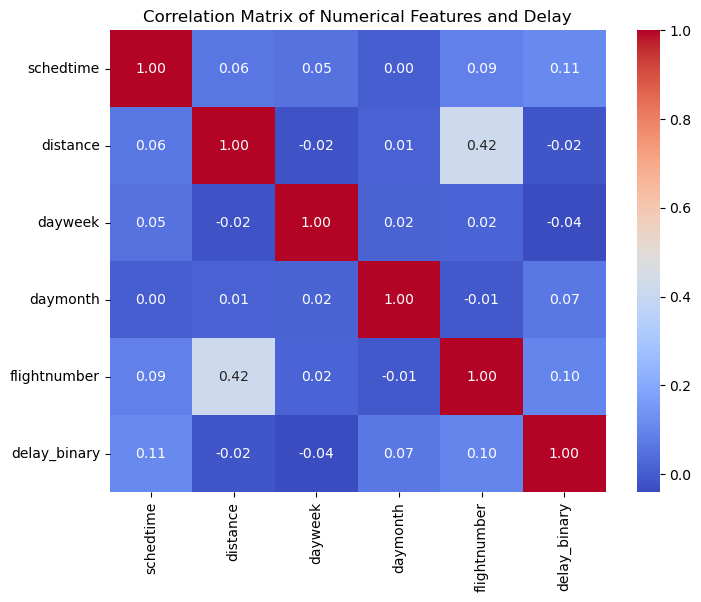

In [105]:
import seaborn as sns
import matplotlib.pyplot as plt

flight_corr = flight.copy()

flight_corr["delay_binary"] = flight_corr["delay"].map({
    "ontime": 0,
    "delayed": 1
})

corr_features = [
    "schedtime",
    "distance",
    "dayweek",
    "daymonth",
    "flightnumber",
    "delay_binary",
]

plt.figure(figsize=(8, 6))
sns.heatmap(
    flight_corr[corr_features].corr(),
    annot=True,
    cmap="coolwarm",
    fmt=".2f"
)
plt.title("Correlation Matrix of Numerical Features and Delay")
plt.show()



In [106]:
# =============================================================================
# FULL PIPELINE (CLASSIFICATION):
# - Build preprocessing
# - Stratified train/test split (by label)
# - Train & log 4 models WITHOUT PCA (RidgeCls, HGB, XGBoost, LightGBM)
# - Train & log 4 models WITH PCA (preprocessing + PCA(0.95) + model)
# - Pick GLOBAL best among 8 models by Test F1
# - Save the global best model
# =============================================================================

import os
import numpy as np
import time

from dotenv import load_dotenv

from sklearn.decomposition import PCA
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.base import clone

import mlflow
from mlflow.models import infer_signature
import joblib

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from flightdelays_pipeline import build_preprocessing, make_estimator_for_name


start_time = time.monotonic()
RANDOM_STATE = 42


In [107]:
preprocessing = build_preprocessing()
print("✓ STEP 1: Preprocessing pipeline created.")


✓ STEP 1: Preprocessing pipeline created.


In [108]:
y = flight["delay"].map({"ontime": 0, "delayed": 1}).astype(int)

X = flight.drop(["flight_id", "delay"], axis=1).copy()
# 这里先不扔 deptime/tailnu；你也可以后面再做对比实验
# 如果你想更“严格避免信息泄露”，可以删 deptime。

train_set, test_set = train_test_split(
    flight,
    test_size=0.20,
    stratify=y,
    random_state=RANDOM_STATE,
)

X_train = train_set.drop(["flight_id", "delay"], axis=1).copy()
y_train = train_set["delay"].map({"ontime": 0, "delayed": 1}).astype(int).copy()

X_test = test_set.drop(["flight_id", "delay"], axis=1).copy()
y_test = test_set["delay"].map({"ontime": 0, "delayed": 1}).astype(int).copy()

print(f"✓ STEP 2: Stratified split done. Train size: {len(X_train)}, Test size: {len(X_test)}")
print("Train class balance:", y_train.value_counts().to_dict())
print("Test class balance:", y_test.value_counts().to_dict())


✓ STEP 2: Stratified split done. Train size: 1760, Test size: 441
Train class balance: {0: 1418, 1: 342}
Test class balance: {0: 355, 1: 86}


In [109]:
models = {}
for name in ["ridge", "histgradientboosting", "xgboost", "lightgbm"]:
    est = make_estimator_for_name(name)
    models[name] = make_pipeline(preprocessing, est)

print("✓ STEP 3: 4 baseline model pipelines defined.")


✓ STEP 3: 4 baseline model pipelines defined.


In [110]:
                
# import dagshub
# dagshub.init(repo_owner='xiaowei251129',
#              repo_name='my-first-repo',
#              mlflow=True)

# 如果你还没准备 DagsHub .env，可以先注释掉 load_dotenv + set_tracking_uri
load_dotenv(dotenv_path=f"{base_folder}/xiaowei_notebooks/.env", override=True)
MLFLOW_TRACKING_URI = os.getenv("MLFLOW_TRACKING_URI")
MLFLOW_TRACKING_USERNAME = os.getenv("MLFLOW_TRACKING_USERNAME")
MLFLOW_TRACKING_PASSWORD = os.getenv("MLFLOW_TRACKING_PASSWORD")
if MLFLOW_TRACKING_USERNAME: os.environ["MLFLOW_TRACKING_USERNAME"] = MLFLOW_TRACKING_USERNAME
if MLFLOW_TRACKING_PASSWORD: os.environ["MLFLOW_TRACKING_PASSWORD"] = MLFLOW_TRACKING_PASSWORD
if MLFLOW_TRACKING_URI: mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)

# mlflow.set_tracking_uri("file:./mlruns")   # 强制用本地这个目录
mlflow.set_experiment("flightdelays_multi_model")
print("✓ STEP 4: MLflow configured.")


2025/12/18 14:06:34 INFO mlflow.tracking.fluent: Experiment with name 'flightdelays_multi_model' does not exist. Creating a new experiment.


✓ STEP 4: MLflow configured.


In [111]:
results = {}

for name, pipeline in models.items():
    print(f"\n{'=' * 80}")
    print(f"Training baseline model: {name}")
    print(f"{'=' * 80}")

    cv_scores = cross_val_score(
        pipeline, X_train, y_train,
        cv=3, scoring="f1", n_jobs=-1
    )
    cv_f1 = float(cv_scores.mean())
    print(f"{name} (no PCA) CV F1: {cv_f1:.4f}")

    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_test)
    test_f1 = float(f1_score(y_test, y_pred))
    print(f"{name} (no PCA) Test F1: {test_f1:.4f}")

    results[name] = {"pipeline": pipeline, "test_f1": test_f1, "cv_f1": cv_f1}

    with mlflow.start_run(run_name=f"{name}_baseline"):
        mlflow.log_param("model_family", name)
        mlflow.log_param("uses_pca", False)

        est_step_name = list(pipeline.named_steps.keys())[-1]
        est = pipeline.named_steps[est_step_name]
        est_params = {f"{est_step_name}__{k}": v for k, v in est.get_params().items()}
        mlflow.log_params(est_params)

        mlflow.log_metric("cv_F1", cv_f1)
        mlflow.log_metric("test_F1", test_f1)

        signature = infer_signature(X_train, pipeline.predict(X_train))
        mlflow.sklearn.log_model(
            sk_model=pipeline,
            artifact_path="flightdelays_model",
            signature=signature,
            input_example=X_train,
            registered_model_name=f"{name}_pipeline",
        )

print("\n✓ STEP 5: All 4 baseline models trained and logged.")



Training baseline model: ridge
ridge (no PCA) CV F1: 0.3979
ridge (no PCA) Test F1: 0.3698


/opt/anaconda3/lib/python3.13/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Successfully registered model 'ridge_pipeline'.
2025/12/18 14:06:46 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: ridge_pipeline, version 1
Created version '1' of mo

🏃 View run ridge_baseline at: https://dagshub.com/xiaowei251129/xiaowei_finalproject.mlflow/#/experiments/1/runs/3a5a55df6bf349ec8368ebf92e6c8e42
🧪 View experiment at: https://dagshub.com/xiaowei251129/xiaowei_finalproject.mlflow/#/experiments/1

Training baseline model: histgradientboosting
histgradientboosting (no PCA) CV F1: 0.4457
histgradientboosting (no PCA) Test F1: 0.4545


/opt/anaconda3/lib/python3.13/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Successfully registered model 'histgradientboosting_pipeline'.
2025/12/18 14:07:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: histgradientboosting_pipeline, versi

🏃 View run histgradientboosting_baseline at: https://dagshub.com/xiaowei251129/xiaowei_finalproject.mlflow/#/experiments/1/runs/a123baa9241046718b59d678b8716e55
🧪 View experiment at: https://dagshub.com/xiaowei251129/xiaowei_finalproject.mlflow/#/experiments/1

Training baseline model: xgboost
xgboost (no PCA) CV F1: 0.4663
xgboost (no PCA) Test F1: 0.4088


/opt/anaconda3/lib/python3.13/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Successfully registered model 'xgboost_pipeline'.
2025/12/18 14:07:24 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: xgboost_pipeline, version 1
Created version '1' o

🏃 View run xgboost_baseline at: https://dagshub.com/xiaowei251129/xiaowei_finalproject.mlflow/#/experiments/1/runs/ebbc66d4124941329fa49bc859a130bd
🧪 View experiment at: https://dagshub.com/xiaowei251129/xiaowei_finalproject.mlflow/#/experiments/1

Training baseline model: lightgbm


/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


lightgbm (no PCA) CV F1: 0.4817


/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


lightgbm (no PCA) Test F1: 0.4675


/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklear

🏃 View run lightgbm_baseline at: https://dagshub.com/xiaowei251129/xiaowei_finalproject.mlflow/#/experiments/1/runs/7bebfea8726d4157ae3f619ea260eb4a
🧪 View experiment at: https://dagshub.com/xiaowei251129/xiaowei_finalproject.mlflow/#/experiments/1

✓ STEP 5: All 4 baseline models trained and logged.


In [112]:
pca_results = {}

for name in models.keys():
    print("\n" + "=" * 80)
    print(f"Training PCA-augmented model: {name}")
    print("=" * 80)

    est = make_estimator_for_name(name)

    pca_pipeline = make_pipeline(
        preprocessing,
        PCA(n_components=0.95),
        est,
    )

    cv_scores_pca = cross_val_score(
        pca_pipeline, X_train, y_train,
        cv=3, scoring="f1", n_jobs=-1
    )
    cv_f1_pca = float(cv_scores_pca.mean())
    print(f"{name}_with_pca CV F1: {cv_f1_pca:.4f}")

    pca_pipeline.fit(X_train, y_train)

    y_pred_pca = pca_pipeline.predict(X_test)
    test_f1_pca = float(f1_score(y_test, y_pred_pca))

    model_key = f"{name}_with_pca"
    pca_results[model_key] = {
        "pipeline": pca_pipeline,
        "test_f1": test_f1_pca,
        "cv_f1": cv_f1_pca,
    }

    print(f"{model_key} Test F1: {test_f1_pca:.4f}")

    with mlflow.start_run(run_name=model_key):
        mlflow.log_param("model_family", name)
        mlflow.log_param("uses_pca", True)

        est_step_name = list(pca_pipeline.named_steps.keys())[-1]
        est_step = pca_pipeline.named_steps[est_step_name]
        est_params = {f"{est_step_name}__{k}": v for k, v in est_step.get_params().items()}
        mlflow.log_params(est_params)

        pca_step = pca_pipeline.named_steps["pca"]
        mlflow.log_param("pca__n_components", pca_step.n_components)

        mlflow.log_metric("cv_F1", cv_f1_pca)
        mlflow.log_metric("test_F1", test_f1_pca)

        signature_pca = infer_signature(X_train, pca_pipeline.predict(X_train))
        mlflow.sklearn.log_model(
            sk_model=pca_pipeline,
            artifact_path="flightdelays_model_with_pca",
            signature=signature_pca,
            input_example=X_train,
            registered_model_name=f"{name}_pipeline_with_pca",
        )

print("\n✓ STEP 7: All 4 PCA models trained and logged.")



Training PCA-augmented model: ridge
ridge_with_pca CV F1: 0.3688
ridge_with_pca Test F1: 0.3787


/opt/anaconda3/lib/python3.13/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Successfully registered model 'ridge_pipeline_with_pca'.
2025/12/18 14:08:05 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: ridge_pipeline_with_pca, version 1
Created

🏃 View run ridge_with_pca at: https://dagshub.com/xiaowei251129/xiaowei_finalproject.mlflow/#/experiments/1/runs/3c35df888ddf4ff7b1934ff0b4d4b208
🧪 View experiment at: https://dagshub.com/xiaowei251129/xiaowei_finalproject.mlflow/#/experiments/1

Training PCA-augmented model: histgradientboosting
histgradientboosting_with_pca CV F1: 0.3146
histgradientboosting_with_pca Test F1: 0.2564


/opt/anaconda3/lib/python3.13/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Successfully registered model 'histgradientboosting_pipeline_with_pca'.
2025/12/18 14:08:26 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: histgradientboosting_pipeli

🏃 View run histgradientboosting_with_pca at: https://dagshub.com/xiaowei251129/xiaowei_finalproject.mlflow/#/experiments/1/runs/c1f31bfc541a446e886284011288f5eb
🧪 View experiment at: https://dagshub.com/xiaowei251129/xiaowei_finalproject.mlflow/#/experiments/1

Training PCA-augmented model: xgboost
xgboost_with_pca CV F1: 0.3077
xgboost_with_pca Test F1: 0.2478


/opt/anaconda3/lib/python3.13/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Successfully registered model 'xgboost_pipeline_with_pca'.
2025/12/18 14:08:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: xgboost_pipeline_with_pca, version 1
Cre

🏃 View run xgboost_with_pca at: https://dagshub.com/xiaowei251129/xiaowei_finalproject.mlflow/#/experiments/1/runs/e4d865ad68c242d4b1e373483f823b69
🧪 View experiment at: https://dagshub.com/xiaowei251129/xiaowei_finalproject.mlflow/#/experiments/1

Training PCA-augmented model: lightgbm


/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


lightgbm_with_pca CV F1: 0.3302


/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


lightgbm_with_pca Test F1: 0.2857


/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklear

🏃 View run lightgbm_with_pca at: https://dagshub.com/xiaowei251129/xiaowei_finalproject.mlflow/#/experiments/1/runs/d53a6aad88194458b2bcc12f13cf10a5
🧪 View experiment at: https://dagshub.com/xiaowei251129/xiaowei_finalproject.mlflow/#/experiments/1

✓ STEP 7: All 4 PCA models trained and logged.


In [113]:
all_results = {}
all_results.update(results)
all_results.update(pca_results)

global_best_name = max(all_results, key=lambda k: all_results[k]["test_f1"])
global_best_test_f1 = all_results[global_best_name]["test_f1"]
global_best_cv_f1 = all_results[global_best_name]["cv_f1"]
global_best_pipeline = all_results[global_best_name]["pipeline"]

uses_pca = "with_pca" in global_best_name

print("\n" + "=" * 80)
print("GLOBAL BEST MODEL (ACROSS 8 CANDIDATES)")
print("=" * 80)
print(f"Global best model key: {global_best_name}")
print(f"Global best CV F1:     {global_best_cv_f1:.4f}")
print(f"Global best Test F1:   {global_best_test_f1:.4f}")
print(f"Uses PCA:              {uses_pca}")



GLOBAL BEST MODEL (ACROSS 8 CANDIDATES)
Global best model key: lightgbm
Global best CV F1:     0.4817
Global best Test F1:   0.4675
Uses PCA:              False


In [114]:
def save_model(model, filename="global_best_model.pkl"):
    joblib.dump(model, filename)
    print(f"✓ Model saved to {filename}")

os.makedirs(f"{base_folder}/models", exist_ok=True)

print("\n" + "-" * 80)
print("Saving and reloading GLOBAL best model...")
print("-" * 80)

save_model(global_best_pipeline, filename=f"{base_folder}/models/global_best_flightdelays_model.pkl")

print("\nDone:")
print(f"- GLOBAL best model key: {global_best_name}")
print(f"- GLOBAL best CV F1:     {global_best_cv_f1:.4f}")
print(f"- GLOBAL best Test F1:   {global_best_test_f1:.4f}")

end_time = time.monotonic()
elapsed_time = end_time - start_time
minutes = int(elapsed_time // 60)
seconds = elapsed_time % 60
print(f"Elapsed time: {minutes} minutes and {seconds:.2f} seconds")



--------------------------------------------------------------------------------
Saving and reloading GLOBAL best model...
--------------------------------------------------------------------------------
✓ Model saved to /Users/chengxiaowei/Desktop/Python/eas503/Xiaowei_finalProject/models/global_best_flightdelays_model.pkl

Done:
- GLOBAL best model key: lightgbm
- GLOBAL best CV F1:     0.4817
- GLOBAL best Test F1:   0.4675
Elapsed time: 2 minutes and 36.77 seconds


In [115]:
preprocessing

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['schedtime', 'distance', 'dayweek',
                                  'daymonth', 'flightnumber']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['weather', 'carrier', 'origin', 'dest'])])

In [116]:
loaded = joblib.load(f"{base_folder}/models/global_best_flightdelays_model.pkl")
print("Reload OK, predict sample:", loaded.predict(X_test.head(3)))


Reload OK, predict sample: [0 0 0]


/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [117]:
print(f"- GLOBAL best model key: {global_best_name}")
print(f"- GLOBAL best CV F1:     {global_best_cv_f1:.4f}")
print(f"- GLOBAL best Test F1:   {global_best_test_f1:.4f}")


- GLOBAL best model key: lightgbm
- GLOBAL best CV F1:     0.4817
- GLOBAL best Test F1:   0.4675


/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


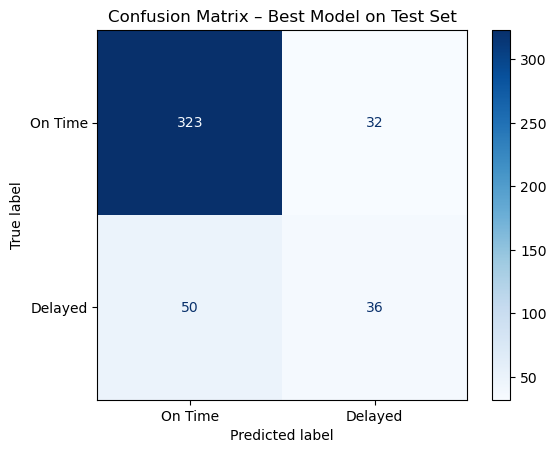

In [118]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_test_pred = global_best_pipeline.predict(X_test)

cm = confusion_matrix(y_test, y_test_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["On Time", "Delayed"]
)

disp.plot(cmap="Blues")
plt.title("Confusion Matrix – Best Model on Test Set")
plt.show()
